# Analysis of News Headlines: Topic Modelling with LSA
In this Project, LSA modelling algorithm is explored. These techniques are applied to the 'A Million News Headlines' dataset, which is a corpus of over one million news article headlines published by the ABC. 

## Import required packages and modules

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import nltk
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
%matplotlib inline

## Import Dataset

In [2]:
file_name = 'abcnews-date-text.csv'
dataframe = pd.read_csv(file_name, parse_dates=[0], infer_datetime_format=True)

data = dataframe['headline_text']
data.index = dataframe['publish_date']

data.head()

publish_date
2003-02-19    aba decides against community broadcasting lic...
2003-02-19       act fire witnesses must be aware of defamation
2003-02-19       a g calls for infrastructure protection summit
2003-02-19             air nz staff in aust strike for pay rise
2003-02-19        air nz strike to affect australian travellers
Name: headline_text, dtype: object

## Exploratory Data Analysis
As usual, it is prudent to begin with some basic exploratory analysis.

In [3]:
# Find number of NaN values and drop them
print(data.isna().sum())
data.dropna(inplace = True)

16


In [4]:
# Pick up sample data from complete data ( You can do operations on entire data it is upto you)
print(data.shape)
data = data[-100001:-1]
print(data.shape)
data.head()

(1082460,)
(100000,)


publish_date
2015-09-21         live malcolm turnbulls new ministry sworn in
2015-09-21    local market down 2.5 per cent as federal rese...
2015-09-21    local share market falls nearly 2pc investor l...
2015-09-21              louise bell murder dieter pfennig trial
2015-09-21    lucille butterworth fourth week of inquest begins
Name: headline_text, dtype: object

In [5]:
# Download Stopwords if not done already
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>


False

In [6]:
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['new','man','says','qld','wa','sa','could','should','first','second','one','two','australia','australian','day','south','year','years','2016','man','woman','home','car','canberra','melbourne','north','south','east','west','adelaide','perth','nsw','sydney',"a", "about", "above", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along", "already", "also","although","always","am","among", "amongst", "amoungst", "amount",  "an", "and", "another", "any","anyhow","anyone","anything","anyway", "anywhere", "are", "around", "as",  "at", "back","be","became", "because","become","becomes", "becoming", "been", "before", "beforehand", "behind", "being", "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom","but", "by", "call", "can", "cannot", "cant", "co", "con", "could", "couldnt", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight", "either", "eleven","else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone", "everything", "everywhere", "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five", "for", "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if", "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made", "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much", "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own","part", "per", "perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take", "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they", "thickv", "thin", "third", "this", "those", "though", "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what", "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves"]
stopwords.extend(newStopWords)

In [7]:
## Define helper functions to get top n words
## Defined function must return a tuple of the top n words in a sample and their 
## accompanying counts, given a CountVectorizer object and text sample

def get_top_n_words(n, vectorizer, text):
    headlines = vectorizer.fit_transform(text.values)
    total = np.sum(headlines, axis=0)
    indices = np.flip(np.argsort(total)[0,:], 1)
    values = np.flip(np.sort(total)[0,:],1)
    
    vectors = np.zeros((n, headlines.shape[1]))
    for i in range(n):
        vectors[i,indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in vectorizer.inverse_transform(vectors)]

    return (words, values[0,:n].tolist()[0])

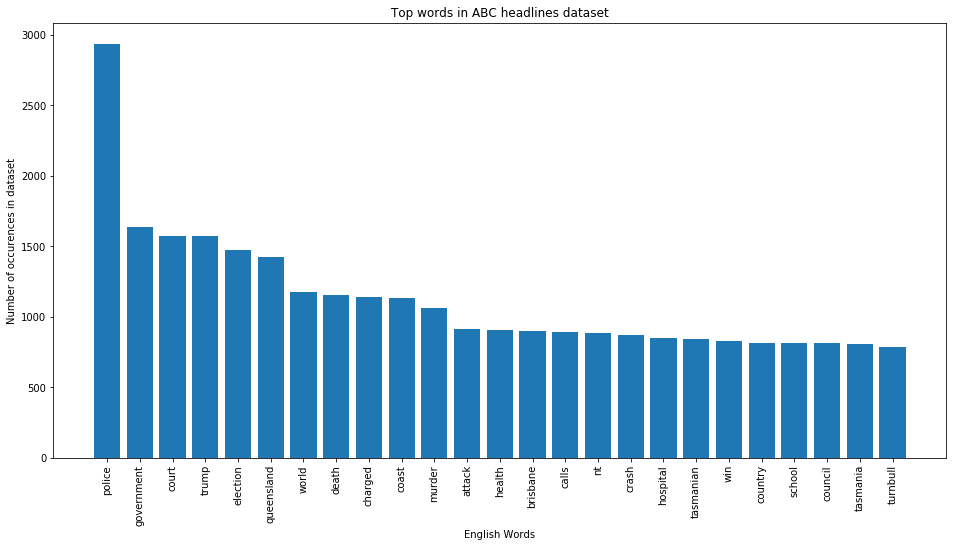

In [8]:
## plot top 25 words in headlines dataset and their number of occurances
## Pass the new created set of stopwords to count vectoriser function
## Initially try to work on a batch of data instead of entire dataset (Say on 200000 examples)

count_vectorizer = CountVectorizer(stop_words=stopwords)
words, word_values = get_top_n_words(n=25,vectorizer=count_vectorizer, text=data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in ABC headlines dataset');
ax.set_xlabel('English Words');
ax.set_ylabel('Number of occurences in dataset');
plt.show()

In [ ]:
## You can download punkt and averaged perceptron tagger for NLTK if required using
## nltk.download('punkt')
## nltk.download('averaged_perceptron_tagger')

In [9]:
## Identify Tagged Headlines

tagged_headlines = [TextBlob(data[i]).pos_tags for i in range(data.shape[0])]

In [10]:
## For furthur analysis one can try finding average headline word length
## and Part of speech tagging for headline corpus

thDataframe = pd.DataFrame({'tags':tagged_headlines})

wordCount = [] 
positionCount = {}

for headline in thDataframe[u'tags']:
    wordCount.append(len(headline))
    for tag in headline:
        if tag[1] in positionCount:
            positionCount[tag[1]] += 1
        else:
            positionCount[tag[1]] = 1

In [11]:
# LSA Topic modelling

NewCountVect = CountVectorizer(stop_words=stopwords, max_features=40000)
DataSample = data.sample(n=100000, random_state=0).values

print('Before vect. headline: {}'.format(DataSample[123]))
TermMatrix = NewCountVect.fit_transform(DataSample)

print('After vect. headline: \n{}'.format(TermMatrix[123]))

Before vect. headline: beijing tells asia pacific no need to choose between china us
After vect. headline: 
  (0, 25544)	1
  (0, 24295)	1
  (0, 35384)	1
  (0, 4575)	1
  (0, 3266)	1
  (0, 7572)	1
  (0, 7515)	1


In [12]:
NoOfTopics = 15

In [13]:
# Defining LSA Model

Model = TruncatedSVD(n_components=NoOfTopics)
TopicMatrix = Model.fit_transform(TermMatrix)

In [14]:
## Define helper functions to get keys that returns an integer list of predicted topic 
## categories for a given topic matrix
## and KeysToCount that returns a tuple of topic categories and their 
## accompanying magnitudes for a given list of keys

def getKeys(topic_matrix):
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def countOfKeys(keys):
    pairs = Counter(keys).items()
    categories = [pair[0] for pair in pairs]
    counts = [pair[1] for pair in pairs]
    return (categories, counts)

In [15]:
keys = getKeys(TopicMatrix)
categories, counts = countOfKeys(keys)
categories
for i in range(15):
    print(categories[i])

9
1
10
13
6
2
8
5
0
12
14
4
7
3
11


In [16]:
## Define helper function get_top_n_words that returns a list of n_topic strings, 
## where each string contains the n most common words in a predicted category, in order

def TopNWords(n, keys, TermMatrix, Vectorizer):
    indices = []
    for topic in range(n):
        Vectorsum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                Vectorsum += TermMatrix[i]
        VectorSum = Vectorsum.toarray()
        NWordIndices = np.flip(np.argsort(VectorSum)[0][-n:],0)
        indices.append(NWordIndices)   
    topWords = []
    for topic in indices:
        topicWords = []
        for index in topic:
            tempWordVector = np.zeros((1,TermMatrix.shape[1]))
            tempWordVector[:,index] = 1
            Word = Vectorizer.inverse_transform(tempWordVector)[0][0]
            topicWords.append(Word.encode('ascii').decode('utf-8'))
        topWords.append(" ".join(topicWords))         
    return topWords

In [17]:
topWordsLSA = TopNWords(15, keys, TermMatrix, NewCountVect)

for i in range(len(topWordsLSA)):
    print("Topic {}: ".format(i+1), topWordsLSA[i])

Topic 1:  police say search missing shooting victoria arrested body officer station arrest shot footage hunt drug
Topic 2:  trump donald china ban deal house president tax debate media power clinton ahead labor obama
Topic 3:  government tasmanian accused federal victorian high face laws act case power drug rail appeal charges
Topic 4:  court hears told high accused murder supreme face alleged faces case charged appears appeal rules
Topic 5:  country 2015 hour drum big october november december wednesday tuesday friday monday podcast thursday september
Topic 6:  election labor live afl campaign party liberal nation liberals blog federal candidates seat candidate abc
Topic 7:  coast gold central storm afl missing cyclone sunshine beach nrl weather shark games sea western
Topic 8:  queensland palmer outback clive nickel drought cyclone laws origin cattle reds rain debbie parliament central
Topic 9:  charged murder guilty pleads trial men mother sentenced jailed stabbing assault alleged a

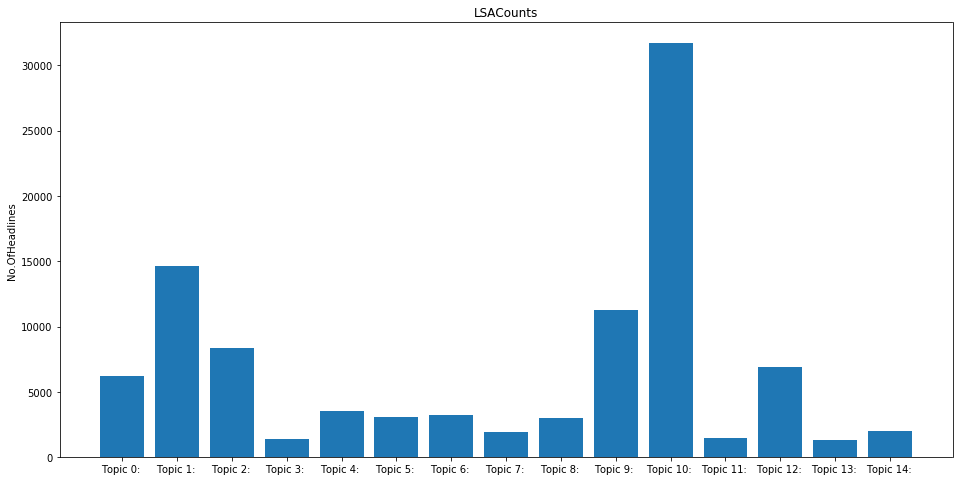

Topic 9:
world league win test cup wins record women final rugby war festival city cricket zealand
Topic 1:
trump donald china ban deal house president tax debate media power clinton ahead labor obama
Topic 10:
calls indigenous school tasmania hospital nt state market water turnbull national minister family people report
Topic 13:
health mental trial rural service minister illness services reporter jury sach patients insurance funding government
Topic 6:
coast gold central storm afl missing cyclone sunshine beach nrl weather shark games sea western
Topic 2:
government tasmanian accused federal victorian high face laws act case power drug rail appeal charges
Topic 8:
charged murder guilty pleads trial men mother sentenced jailed stabbing assault alleged accused death baby
Topic 5:
election labor live afl campaign party liberal nation liberals blog federal candidates seat candidate abc
Topic 0:
police say search missing shooting victoria arrested body officer station arrest shot footage 

In [18]:
## Visualise each topic vs Number of headlines These will be the most discussed topics 

Nwords = TopNWords(15, keys, TermMatrix, NewCountVect)
labels = ['Topic {}: \n'.format(categories[i]) for i in range(15)]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(categories, counts);
ax.set_xticks(categories);
ax.set_xticklabels(labels);
ax.set_ylabel('No.OfHeadlines');
ax.set_title('LSACounts');
plt.show()
for i in categories:
    print('Topic {}:\n'.format(i) + Nwords[i])

## Dimentionality reduction and plotting using TSNE

In [19]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(TopicMatrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.400s...
[t-SNE] Computed neighbors for 100000 samples in 132.572s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional prob

In [21]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(NoOfTopics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [22]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:NoOfTopics]

In [25]:
#Nwords = TopNWords(15, keys, TermMatrix, NewCountVect)
lsa_mean_topic_vectors = get_mean_topic_vectors(keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(NoOfTopics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[keys])

for t in range(NoOfTopics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=Nwords[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)